In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

sys.path.insert(0,'../')
from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_gbk_metadata, read_phage_locations

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA


import subprocess
import gzip


In [2]:
rv = re.compile('^\\w+')
def remove_ver(x):
    return rv.search(str(x)).group()

# Read the phages

Read the phage genomes, regardless of how many contigs (we'll filter later)

In [3]:
phagesdf = read_phages(maxcontigs=-1) # this disables contig length filtering
phagesdf['assembly_nover'] = phagesdf['GENOMEID'].apply(remove_ver)
phagesdf['fraction_kept'] = phagesdf['Kept']/(phagesdf['Kept']+phagesdf['No_phage_genes'])
phagesdf['fraction_kept'].fillna(0, inplace=True)
phagesdf['missed_phages'] = 1/phagesdf['Kept']
phagesdf['missed_phages'].fillna(1, inplace=True)
phagesdf

Please note that this was run with git commit c17d066 that has 1,195,494 genomes parsed.
Initially there were 5,005,011 kept phages, but after filtering we kept 5,005,011 prophages from 945,685 genomes

,assembly_accession,GENOMEID,Total_bp,Contigs,Contigs_Checked,Total_Predicted_Prophages,Kept,No_phage_genes,Not_enough_genes,bp_of_kept_prophages,bp_no_phage_genes,bp_not_enough_genes,Note,assembly_nover,fraction_kept,missed_phages
2,GCA_008244535.1,GCA_008244535.1,1963348,23,14,17,4,5,8,79796,104676,13431,Complete,GCA_008244535,0.444444,0.250000
3,GCA_008015785.1,GCA_008015785.1,1188656,94,94,35,0,22,13,0,183294,26642,Complete,GCA_008015785,0.000000,inf
4,GCA_001735525.1,GCA_001735525.1,4642543,52,33,30,3,4,23,83559,58207,33920,Complete,GCA_001735525,0.428571,0.333333
5,GCA_019654935.1,GCA_019654935.1,4631520,171,47,13,0,2,11,0,59552,10210,Complete,GCA_019654935,0.000000,inf
6,GCA_019655395.1,GCA_019655395.1,4473905,472,218,11,0,3,8,0,17577,24469,Complete,GCA_019655395,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195489,GCA_020319415.1,GCA_020319415.1,5559579,310,143,76,11,2,63,178853,9738,127058,Complete,GCA_020319415,0.846154,0.090909
1195490,GCA_020319515.1,GCA_020319515.1,5497958,201,116,69,13,1,55,215550,5011,105851,Complete,GCA_020319515,0.928571,0.076923
1195491,GCA_020319535.1,GCA_020319535.1,5294704,195,95,68,9,0,59,114216,0,133228,Complete,GCA_020319535,1.000000,0.111111
1195492,GCA_020319715.1,GCA_020319715.1,4928082,165,87,44,4,0,40,116732,0,73535,Complete,GCA_020319715,1.000000,0.250000


In [4]:
metadf = read_metadata()
metadf['assembly_nover'] = metadf['assembly_accession'].apply(remove_ver)
metadf

,assembly_accession,genome_id,genome_name,organism_name,taxon_id,genome_status,strain,serovar,biovar,pathovar,...,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,comments,additional_metadata,isolation_date,assembly_nover
0,GCA_000003135.1,5.484803e+05,Bifidobacterium longum subsp. longum ATCC 55813,Bifidobacterium longum subsp. longum ATCC 55813,548480,WGS,ATCC 55813,NaN,NaN,NaN,...,Mesophilic,-,NaN,Anaerobic,Host-associated,NaN,Bifidobacterium longum subsp. longum ATCC 5581...,NaN,NaN,GCA_000003135
1,GCA_000003215.1,4.556313e+05,Clostridium difficile QCD-66c26,Clostridium difficile QCD-66c26,455631,WGS,QCD-66c26,NaN,NaN,NaN,...,Mesophilic,37,NaN,Anaerobic,Multiple,Antibiotic-associated Diarrhea;Pseudomembraneo...,Clostridium difficile QCD-66c26. was isolated ...,NaN,NaN,GCA_000003215
2,GCA_000003645.1,5.269733e+05,Bacillus cereus m1293,Bacillus cereus m1293,526973,WGS,m1293,NaN,NaN,NaN,...,Mesophilic,-,NaN,Aerobic,Multiple,Food poisoning,"Bacillus cereus m1293. This strain, also know...",NaN,NaN,GCA_000003645
3,GCA_000003925.1,5.269973e+05,Bacillus mycoides DSM 2048,Bacillus mycoides DSM 2048,526997,WGS,DSM 2048,NaN,NaN,NaN,...,NaN,-,NaN,NaN,NaN,NaN,Bacillus mycoides DSM 2048. Bacillus mycoides...,NaN,NaN,GCA_000003925
4,GCA_000003955.1,5.269943e+05,Bacillus cereus AH1273,Bacillus cereus AH1273,526994,WGS,AH1273,NaN,NaN,NaN,...,Mesophilic,-,NaN,Aerobic,Multiple,Food poisoning,Bacillus cereus AH1273. This strain was isola...,NaN,NaN,GCA_000003955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335550,GCF_900167595.1,1.496160e+03,Clostridioides difficile strain VRECD0186,NaN,1496,WGS,VRECD0186,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,These data are part of a pre-publication relea...,NaN,2015.510609,GCF_900167595
335551,GCF_900167605.1,1.147123e+06,Caloramator quimbayensis strain USBA 833,NaN,1147123,WGS,USBA 833,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Caloramator quimbayensis USBA 833,NaN,NaN,GCF_900167605
335552,GCF_900167615.1,1.496159e+03,Clostridioides difficile strain CD19,NaN,1496,WGS,CD19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.sanger.ac.uk/resources/downloads/ba...,NaN,2014.511294,GCF_900167615
335553,GCF_900167625.1,1.496159e+03,Clostridioides difficile strain VRECD0076,NaN,1496,WGS,VRECD0076,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,These data are part of a pre-publication relea...,NaN,2014.511294,GCF_900167625


## Get just the representative GTDB data

This ignores the non-representative genomes and trims the data significantly.

In [5]:
gtdbr = read_gtdb(representatives=True)

In [6]:
gtdbr['assembly_nover'] = gtdbr['assembly_accession'].apply(remove_ver)
gtdbr

,assembly_accession,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,...,trna_count,trna_selenocysteine_count,domain,phylum,class,order,family,genus,species,assembly_nover
0,GCA_000012145.1,GB_GCA_000012145.1,0,100.00,0.47,324,o__Rickettsiales (UID3809),211,0.0,1344326,...,33,0,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Rickettsiaceae,Rickettsia,Rickettsia felis,GCA_000012145
3,GCA_000024525.1,GB_GCA_000024525.1,0,100.00,0.89,454,o__Cytophagales (UID2936),336,25.0,7481814,...,47,0,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,Spirosoma linguale,GCA_000024525
6,GCA_000169995.1,GB_GCA_000169995.1,0,96.26,0.90,1066,g__Vibrio (UID4874),378,25.0,4995414,...,69,0,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,Vibrio sp000169995,GCA_000169995
14,GCA_000209515.2,GB_GCA_000209515.2,0,99.57,2.16,507,c__Gammaproteobacteria (UID4444),232,25.0,2656553,...,31,0,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Cellvibrionaceae,Endobugula,Endobugula sp000209515,GCA_000209515
26,GCA_000238815.2,GB_GCA_000238815.2,0,99.56,0.00,347,c__Alphaproteobacteria (UID3305),229,0.0,2254256,...,39,0,Bacteria,Proteobacteria,Alphaproteobacteria,Puniceispirillales,Puniceispirillaceae,HIMB100,HIMB100 sp000238815,GCA_000238815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311412,GCA_904063065.1,RS_GCF_904063065.1,0,100.00,0.81,812,o__Pseudomonadales (UID4488),308,0.0,4417451,...,67,0,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,Pseudomonas_E paraversuta,GCA_904063065
311425,GCA_904846615.1,RS_GCF_904846615.1,0,99.86,0.27,674,o__Pseudomonadales (UID4679),364,0.0,2741819,...,49,0,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Psychrobacter,Psychrobacter sp000586455,GCA_904846615
311456,GCA_905220835.1,RS_GCF_905220835.1,0,99.80,0.38,769,g__Burkholderia (UID4006),248,0.0,7043963,...,52,0,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Paraburkholderia,Paraburkholderia sp905220835,GCA_905220835
311469,GCA_907164905.1,RS_GCF_907164905.1,0,100.00,0.60,454,o__Cytophagales (UID2936),336,0.0,6480666,...,38,0,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Dyadobacter,Dyadobacter sp907164905,GCA_907164905


In [7]:
acccol = 'assembly_nover'
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
gtdbex = pd.concat([gtdbr[acccol], gtdbr[tc], gtdbr[gc]], axis=1)
gtdbex

,assembly_nover,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,gtdb_representative,gtdb_taxonomy,gtdb_type_designation,gtdb_type_designation_sources,gtdb_type_species_of_genus
0,GCA_000012145,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Rickettsiaceae,Rickettsia,Rickettsia felis,GB_GCA_000012145.1,GB_GCA_000012145.1,t,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,type strain of species,LPSN,f
3,GCA_000024525,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,Spirosoma linguale,GB_GCA_000024525.1,GB_GCA_000024525.1,t,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,type strain of species,LPSN,t
6,GCA_000169995,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,Vibrio sp000169995,GB_GCA_000169995.1,GB_GCA_000169995.1,t,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
14,GCA_000209515,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Cellvibrionaceae,Endobugula,Endobugula sp000209515,GB_GCA_000209515.2,GB_GCA_000209515.2,t,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
26,GCA_000238815,Bacteria,Proteobacteria,Alphaproteobacteria,Puniceispirillales,Puniceispirillaceae,HIMB100,HIMB100 sp000238815,GB_GCA_000238815.2,GB_GCA_000238815.2,t,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,not type material,NaN,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311412,GCA_904063065,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,Pseudomonas_E paraversuta,RS_GCF_904063065.1,RS_GCF_904063065.1,t,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,type strain of species,LPSN,f
311425,GCA_904846615,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Psychrobacter,Psychrobacter sp000586455,RS_GCF_904846615.1,RS_GCF_904846615.1,t,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
311456,GCA_905220835,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Paraburkholderia,Paraburkholderia sp905220835,RS_GCF_905220835.1,RS_GCF_905220835.1,t,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
311469,GCA_907164905,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Dyadobacter,Dyadobacter sp907164905,RS_GCF_907164905.1,RS_GCF_907164905.1,t,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,NaN,f


In [8]:
cvtax = pd.merge(gtdbex[['assembly_nover', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']], phagesdf[['assembly_nover', 'Contigs', 'Contigs_Checked', 'Kept', 'No_phage_genes', 'Not_enough_genes', 'fraction_kept']], on='assembly_nover', how='inner')
cvtax = cvtax[cvtax['Contigs'] < 100]
cvtax

,assembly_nover,domain,phylum,class,order,family,genus,species,Contigs,Contigs_Checked,Kept,No_phage_genes,Not_enough_genes,fraction_kept
0,GCA_000012145,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Rickettsiaceae,Rickettsia,Rickettsia felis,3,3,3,1,8,0.750000
1,GCA_000024525,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,Spirosoma linguale,9,9,10,13,39,0.434783
4,GCA_000238815,Bacteria,Proteobacteria,Alphaproteobacteria,Puniceispirillales,Puniceispirillaceae,HIMB100,HIMB100 sp000238815,10,10,2,3,13,0.400000
5,GCA_000307935,Bacteria,Proteobacteria,Gammaproteobacteria,SAR86,D2472,D2472,D2472 sp000307935,13,8,2,1,6,0.666667
7,GCA_000331975,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Blattabacteriaceae,Uzinura,Uzinura diaspidicola,1,1,0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36079,GCA_902459805,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Pandoraea,Pandoraea bronchicola,34,23,7,2,26,0.777778
36080,GCA_902498195,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,Pseudomonas_E fluorescens_BU,36,13,1,7,16,0.125000
36081,GCA_902499555,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Mesonia,Mesonia oceanica,72,29,3,8,12,0.272727
36082,GCA_902506425,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Novosphingobium,Novosphingobium sp902506425,75,42,3,15,11,0.166667


# Keeping most abundant Phyla

# make a violin plot of the kept/no phage genes

In [9]:
min_number_of_genomes = 0

In [10]:
tmpdf = cvtax.groupby('phylum').count()
tmpidx = tmpdf[tmpdf['assembly_nover'] > min_number_of_genomes].index
cvshort = cvtax[cvtax['phylum'].isin(tmpidx)]
print(f"There are {pd.unique(cvshort['phylum']).shape[0]} phyla")

There are 121 phyla


In [11]:
# this converts the data to long form. Sigh
cvshortm = pd.melt(cvshort, id_vars=['phylum'], value_vars=['Kept', 'No_phage_genes'], var_name='Prophage', value_name='Count')

# get all the phyla sorted by # Kept and then by # No phage genes
phyla = pd.unique(list(cvshortm[cvshortm['Prophage'] == 'Kept'].groupby('phylum').count().sort_values(by='Prophage', ascending=False).reset_index()['phylum'])+list(cvshortm[cvshortm['Prophage'] == 'Kept'].groupby('phylum').count().sort_values(by='Prophage', ascending=False).reset_index()['phylum']))
phyla_codes = {x:y for y,x in enumerate(phyla)}

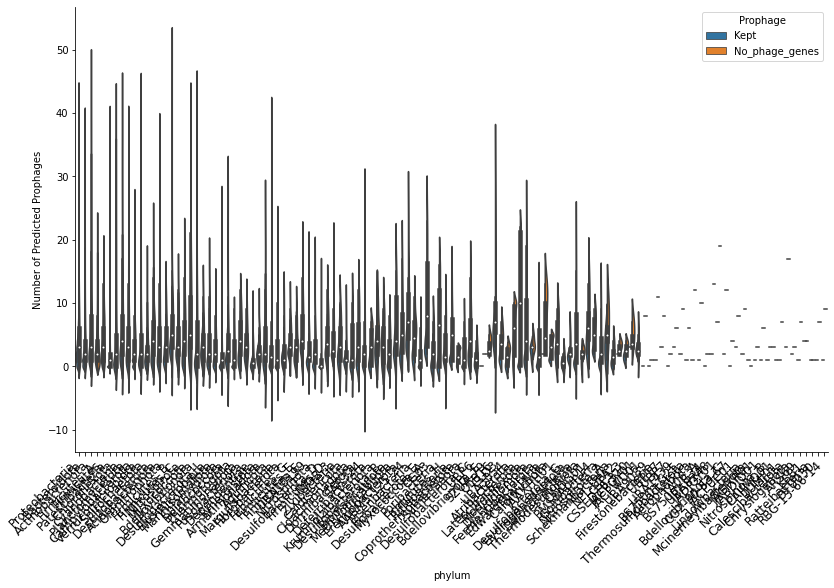

In [12]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.violinplot(x='phylum', y='Count', hue='Prophage', split=True, jitter=True, data=cvshortm, ax=ax, scale='area', 
               inner='box', order=phyla)

ax.set_ylabel("Number of Predicted Prophages")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

plt.tight_layout()


plt.show()

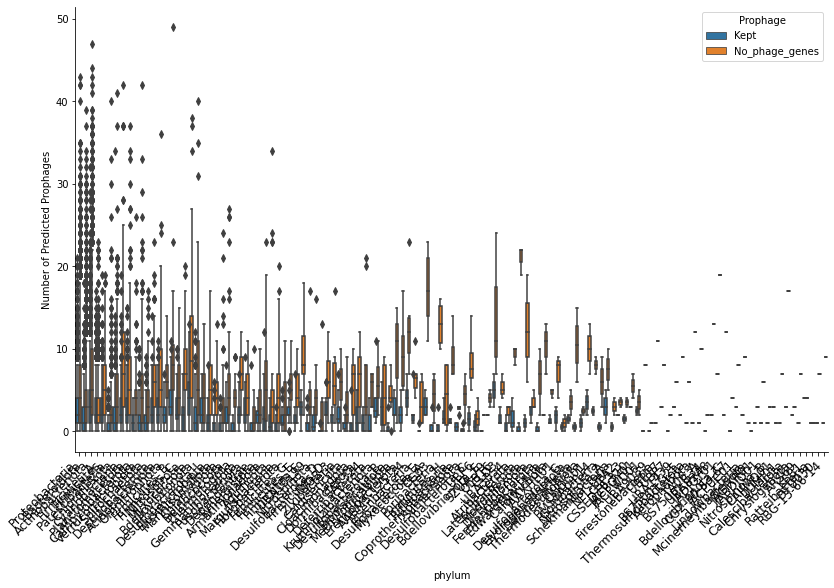

In [13]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.boxplot(x='phylum', y='Count', hue='Prophage', data=cvshortm, ax=ax, order=phyla)

ax.set_ylabel("Number of Predicted Prophages")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

plt.tight_layout()


plt.show()

In [14]:
cvshortm

,phylum,Prophage,Count
0,Proteobacteria,Kept,3
1,Bacteroidota,Kept,10
2,Proteobacteria,Kept,2
3,Proteobacteria,Kept,2
4,Bacteroidota,Kept,0
...,...,...,...
43587,Proteobacteria,No_phage_genes,2
43588,Proteobacteria,No_phage_genes,7
43589,Bacteroidota,No_phage_genes,8
43590,Proteobacteria,No_phage_genes,15


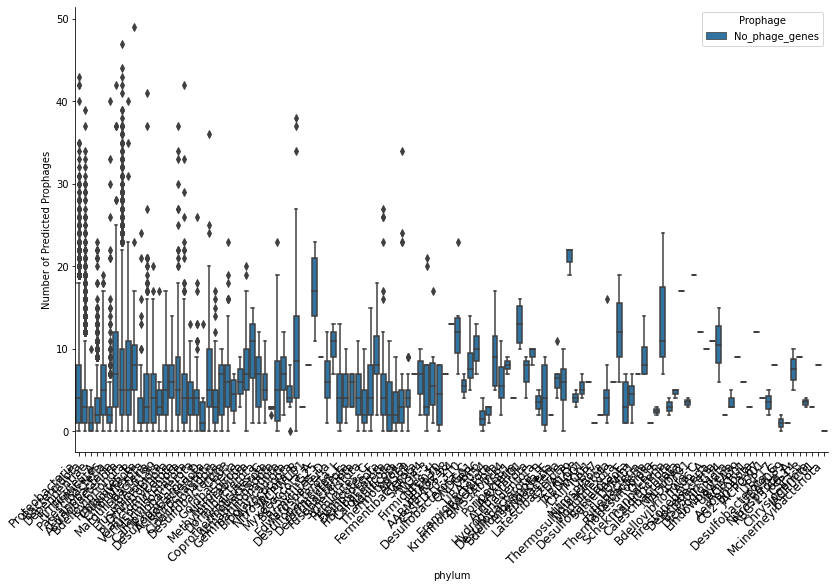

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.boxplot(x='phylum', y='Count', hue='Prophage', data=cvshortm[cvshortm['Prophage'] == 'No_phage_genes'], ax=ax)

ax.set_ylabel("Number of Predicted Prophages")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

plt.tight_layout()


plt.show()

In [16]:
# extract just the No_phage_genes and score them as categories
cvt = cvshortm[cvshortm['Prophage'] == 'No_phage_genes'].copy()
cvt

,phylum,Prophage,Count
21796,Proteobacteria,No_phage_genes,1
21797,Bacteroidota,No_phage_genes,13
21798,Proteobacteria,No_phage_genes,3
21799,Proteobacteria,No_phage_genes,1
21800,Bacteroidota,No_phage_genes,0
...,...,...,...
43587,Proteobacteria,No_phage_genes,2
43588,Proteobacteria,No_phage_genes,7
43589,Bacteroidota,No_phage_genes,8
43590,Proteobacteria,No_phage_genes,15


In [17]:
cvt['phylum_ids'] = [phyla_codes[x] for x in cvt['phylum']]
cvt

,phylum,Prophage,Count,phylum_ids
21796,Proteobacteria,No_phage_genes,1,0
21797,Bacteroidota,No_phage_genes,13,1
21798,Proteobacteria,No_phage_genes,3,0
21799,Proteobacteria,No_phage_genes,1,0
21800,Bacteroidota,No_phage_genes,0,1
...,...,...,...,...
43587,Proteobacteria,No_phage_genes,2,0
43588,Proteobacteria,No_phage_genes,7,0
43589,Bacteroidota,No_phage_genes,8,1
43590,Proteobacteria,No_phage_genes,15,0


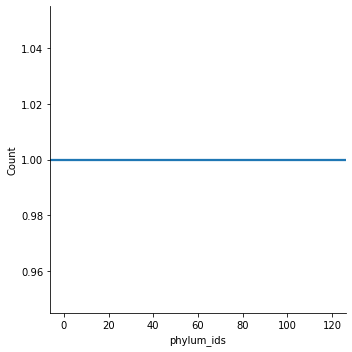

In [18]:
g = sns.lmplot(x="phylum_ids", y="Count", data=cvt, y_jitter=.02, logistic=True, truncate=False, scatter=False)

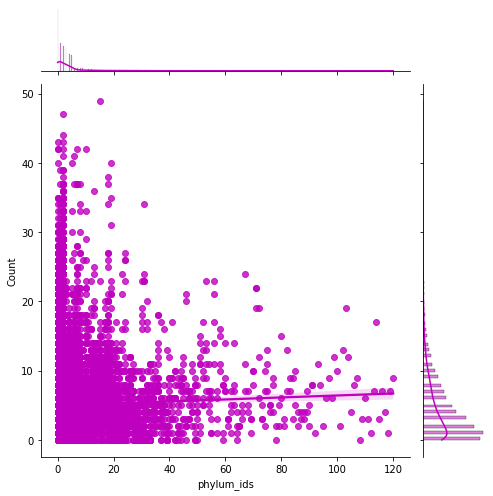

In [19]:
sns.jointplot(x="phylum_ids", y="Count", data=cvt,
                  kind="reg", 
                  color="m", height=7)


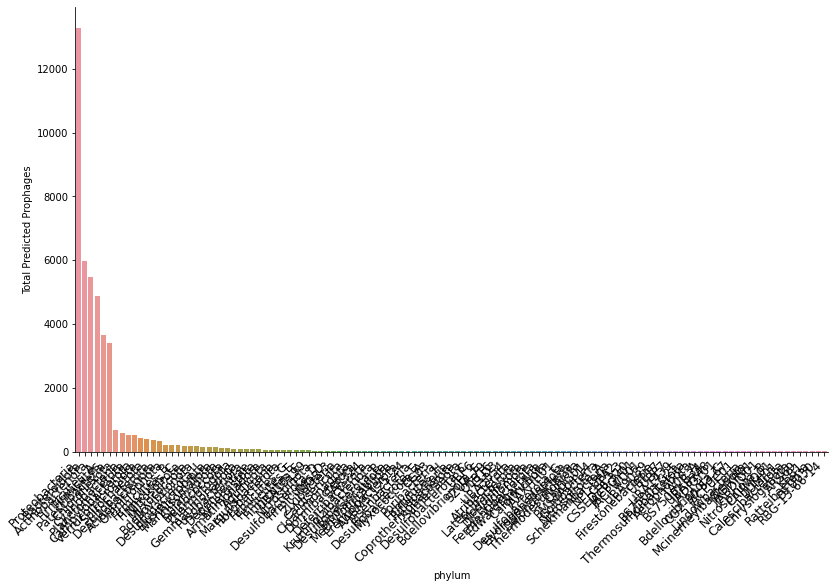

In [20]:
ccts = cvshortm.groupby('phylum').count().sort_values(['Prophage'], ascending=False).reset_index()

fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.barplot(x='phylum', y='Prophage', data=ccts)

ax.set_ylabel("Total Predicted Prophages")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

plt.tight_layout()

plt.show()

### Proportion of kept/not kept phages

In [21]:
cvshort

,assembly_nover,domain,phylum,class,order,family,genus,species,Contigs,Contigs_Checked,Kept,No_phage_genes,Not_enough_genes,fraction_kept
0,GCA_000012145,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Rickettsiaceae,Rickettsia,Rickettsia felis,3,3,3,1,8,0.750000
1,GCA_000024525,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,Spirosoma linguale,9,9,10,13,39,0.434783
4,GCA_000238815,Bacteria,Proteobacteria,Alphaproteobacteria,Puniceispirillales,Puniceispirillaceae,HIMB100,HIMB100 sp000238815,10,10,2,3,13,0.400000
5,GCA_000307935,Bacteria,Proteobacteria,Gammaproteobacteria,SAR86,D2472,D2472,D2472 sp000307935,13,8,2,1,6,0.666667
7,GCA_000331975,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Blattabacteriaceae,Uzinura,Uzinura diaspidicola,1,1,0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36079,GCA_902459805,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Pandoraea,Pandoraea bronchicola,34,23,7,2,26,0.777778
36080,GCA_902498195,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,Pseudomonas_E fluorescens_BU,36,13,1,7,16,0.125000
36081,GCA_902499555,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Mesonia,Mesonia oceanica,72,29,3,8,12,0.272727
36082,GCA_902506425,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Novosphingobium,Novosphingobium sp902506425,75,42,3,15,11,0.166667


In [22]:
cvshortfk = pd.melt(cvshort, id_vars=['phylum'], value_vars=['fraction_kept'], var_name='Prophage', value_name='Count')
cvshortfk

,phylum,Prophage,Count
0,Proteobacteria,fraction_kept,0.750000
1,Bacteroidota,fraction_kept,0.434783
2,Proteobacteria,fraction_kept,0.400000
3,Proteobacteria,fraction_kept,0.666667
4,Bacteroidota,fraction_kept,0.000000
...,...,...,...
21791,Proteobacteria,fraction_kept,0.777778
21792,Proteobacteria,fraction_kept,0.125000
21793,Bacteroidota,fraction_kept,0.272727
21794,Proteobacteria,fraction_kept,0.166667


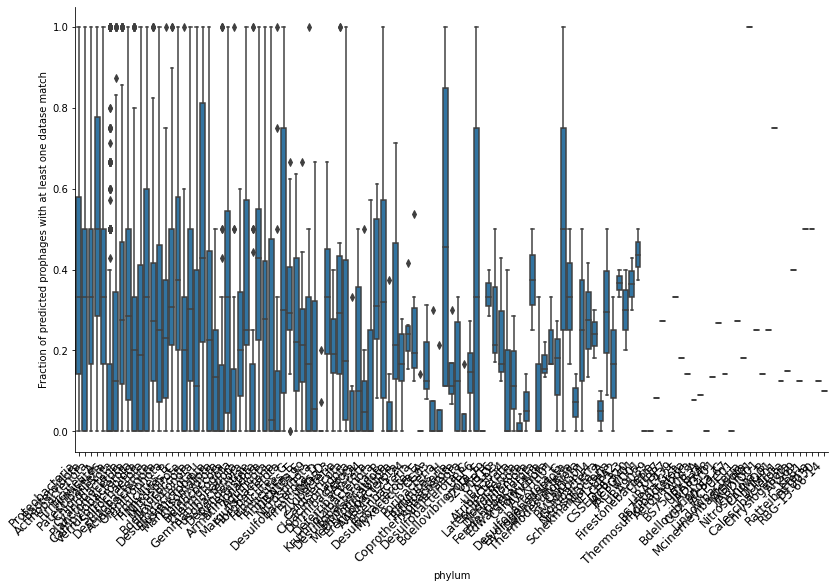

In [23]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.boxplot(x='phylum', y='Count', hue='Prophage', data=cvshortfk, ax=ax, order=phyla)

ax.get_legend().remove()

ax.set_ylabel("Fraction of predicted prophages with at least one datase match")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

plt.tight_layout()


plt.show()

In [24]:
cvshortfkn = pd.melt(cvshort[cvshort['No_phage_genes'] > 0], id_vars=['phylum'], value_vars=['fraction_kept'], var_name='Prophage', value_name='Count')

In [25]:
print(f"All: {cvshortfk.shape} Trimmed: {cvshortfkn.shape}")

All: (21796, 3) Trimmed: (18833, 3)


/local/edwa0468/946474/ipykernel_3758697/2760669529.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)


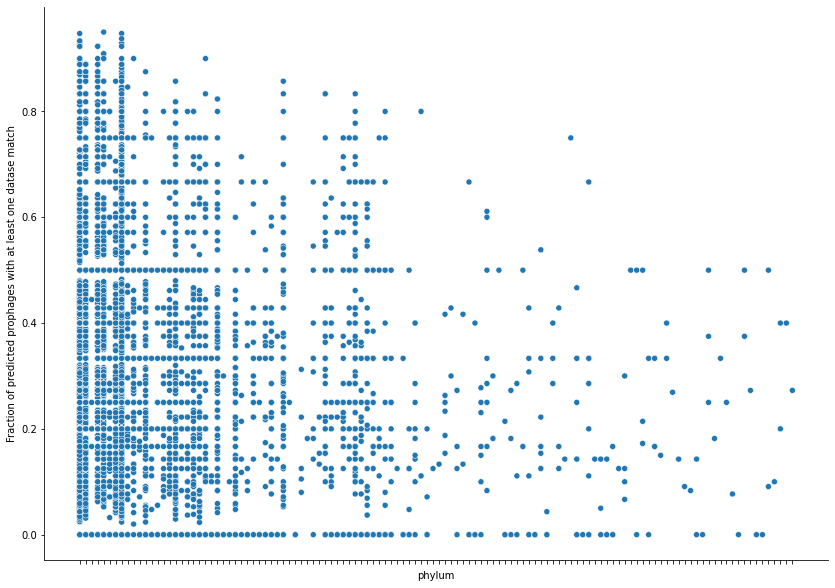

In [26]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.scatterplot(x='phylum', y='Count', hue='Prophage', data=cvshortfkn, ax=ax)

ax.get_legend().remove()

ax.set_ylabel("Fraction of predicted prophages with at least one datase match")

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

plt.tight_layout()


plt.show()

# Bootstrapping the data

In [27]:
cvshortfk = pd.melt(cvshort, id_vars=['phylum'], value_vars=['fraction_kept'], var_name='Prophage', value_name='Count')
cvshortfk

,phylum,Prophage,Count
0,Proteobacteria,fraction_kept,0.750000
1,Bacteroidota,fraction_kept,0.434783
2,Proteobacteria,fraction_kept,0.400000
3,Proteobacteria,fraction_kept,0.666667
4,Bacteroidota,fraction_kept,0.000000
...,...,...,...
21791,Proteobacteria,fraction_kept,0.777778
21792,Proteobacteria,fraction_kept,0.125000
21793,Bacteroidota,fraction_kept,0.272727
21794,Proteobacteria,fraction_kept,0.166667
